# Importing

In [8]:
#from google.colab import drive
#drive.mount('/content/drive')

In [9]:
import cv2
import matplotlib.pyplot as plt

left = cv2.imread("undLeft.png")
#left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)[:,512:3552]
left = left[:,512:3552]

right = cv2.imread("undRight.png")
#right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)[:,512:3552]
right = right[:,512:3552]

# Generating mask and pyramid

In [10]:
a = 150
b = 200
maskL = cv2.inRange(left, (a,a,a), (b,b,b))
maskL = cv2.bitwise_not(maskL)
maskR = cv2.inRange(right, (a,a,a), (b,b,b))
maskR = cv2.bitwise_not(maskR)

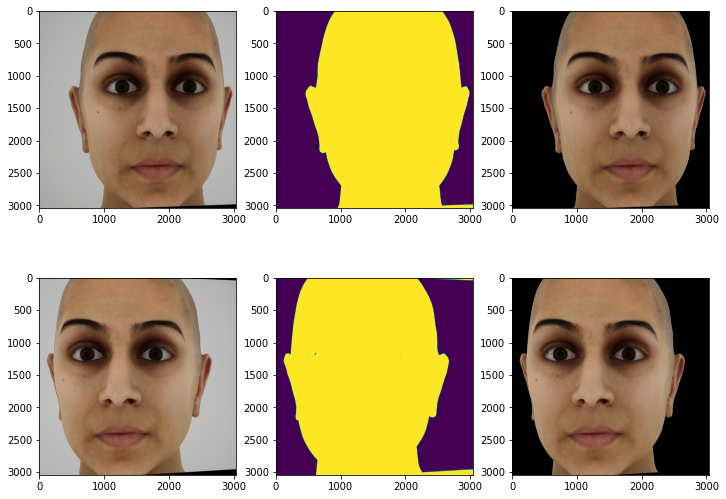

In [11]:
fig, axs = plt.subplots(2,3,figsize=(12,9))
axs[0][0].imshow(left)
axs[0][1].imshow(maskL)
axs[0][2].imshow(cv2.bitwise_and(left, left, mask=maskL))
axs[1][0].imshow(right)
axs[1][1].imshow(maskR)
axs[1][2].imshow(cv2.bitwise_and(right, right, mask=maskR))

In [12]:
leftPyr = [left]
rightPyr = [right]
for i in range(5):
  left = cv2.pyrDown(left, dstsize=(left.shape[0] // 2, left.shape[1] // 2))
  right = cv2.pyrDown(right, dstsize=(right.shape[0]//2, right.shape[1]//2))
  leftPyr.append(left)
  rightPyr.append(right)

# Pixel Matching Test

Matching pixel at: 7
Disparity:  13


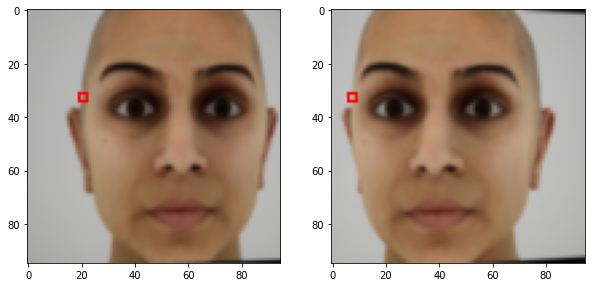

In [13]:
i=32
j=20
leftimg = leftPyr[-1].copy()
rightimg = rightPyr[-1].copy()

temp = leftimg[i-1:i+2, j-1:j+2]
res = cv2.matchTemplate(rightimg[i-1:i+2,:], temp, cv2.TM_CCORR_NORMED)

recl = leftimg.copy()
cv2.rectangle(recl, (j-1,i-1), (j+2,i+2), (255,0,0), 1)
recr = rightimg.copy()

m = res.argmax()
print('Matching pixel at:', m+1)
print('Disparity: ', j-m-1)

cv2.rectangle(recr, (m,i-1), (m+3,i+2), (255,0,0), 1)

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(recl)
axs[1].imshow(recr)
plt.show()

# Disparity Map

In [14]:
import numpy as np

leftimg = leftPyr[-1].copy()
rightimg = rightPyr[-1].copy()

dispMapLeft = np.zeros(leftimg.shape[:2])
dispMapRight = np.zeros(leftimg.shape[:2])
matchLeft = np.zeros(leftimg.shape[:2])
matchRight = np.zeros(rightimg.shape[:2])

for i in range(1, leftimg.shape[0]-1):
  for j in range(1, leftimg.shape[1]-1):
    temp = leftimg[i-1:i+2, j-1:j+2]
    res = cv2.matchTemplate(rightimg[i-1:i+2,:], temp, cv2.TM_CCORR_NORMED)
    matchLeft[i][j] = res.argmax()+1
    dispMapLeft[i][j] = j-res.argmax()-1

for i in range(1, rightimg.shape[0]-1):
  for j in range(1, rightimg.shape[1]-1):
    temp = rightimg[i-1:i+2, j-1:j+2]
    res = cv2.matchTemplate(leftimg[i-1:i+2,:], temp, cv2.TM_CCORR_NORMED)
    matchRight[i][j] = res.argmax()+1
    dispMapRight[i][j] = j-res.argmax()-1

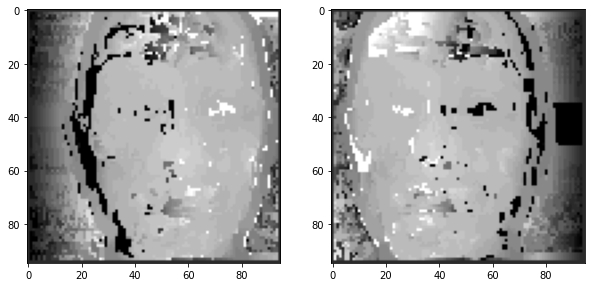

In [15]:
mapL = dispMapLeft.copy()
mapR = dispMapRight.copy()
mapL[mapL<-5] =-5
mapL[mapL> 25] = 25
mapR[mapR> 5] = 5
mapR[mapR<-25] =-25
fig,axs = plt.subplots(1,2,figsize=(10,20))
axs[0].imshow(mapL, cmap='gray')
axs[1].imshow(25-mapR, cmap='gray')

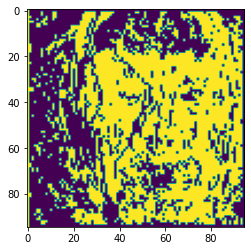

In [16]:
uniqueness = np.ndarray(dispMapLeft.shape, dtype='uint8')
for i in range(dispMapLeft.shape[0]):
  for j in range(dispMapLeft.shape[1]):
    if(matchRight[i, int(matchLeft[i, j])] == j):
      uniqueness[i][j] = 255
    else:
      uniqueness[i][j] = 0

plt.imshow(uniqueness)

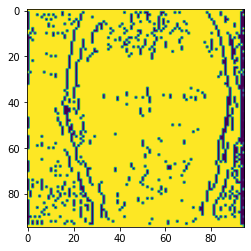

In [17]:
ordering = np.ndarray(dispMapLeft.shape, dtype='uint8')
for i in range(dispMapLeft.shape[0]):
  for j in range(dispMapLeft.shape[1]-1):
    if(dispMapLeft[i,j]-dispMapLeft[i,j+1] <= 1):
      ordering[i][j] = 255
    else:
      ordering[i][j] = 0

plt.imshow(ordering)

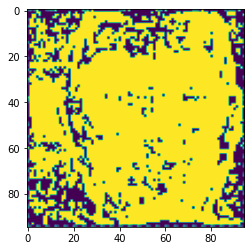

In [18]:
smoothness = np.ndarray(dispMapLeft.shape, dtype='uint8')

for i in range(1,dispMapLeft.shape[0]-1):
  for j in range(1,dispMapLeft.shape[1]-1):
    morethanone = 0
    for x in range(-1,2):
      for y in range(-1,2):
        if(abs(dispMapLeft[i,j]-dispMapLeft[i+x,j+y]) > 1):
          morethanone += 1
    if(morethanone <= 4):
      smoothness[i][j] = 255
    else:
      smoothness[i][j] = 0


plt.imshow(smoothness)

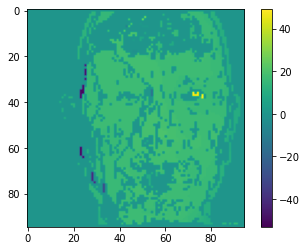

In [19]:
faceDisp = cv2.bitwise_and(dispMapLeft, dispMapLeft, mask=uniqueness)
faceDisp = cv2.bitwise_and(faceDisp, faceDisp, mask=smoothness)
faceDisp = cv2.bitwise_and(faceDisp, faceDisp, mask=ordering)
masknew = cv2.inRange(leftPyr[-1], (a,a,a), (b,b,b))
masknew = cv2.bitwise_not(masknew)
faceDisp = cv2.bitwise_and(faceDisp, faceDisp, mask=masknew)
plt.imshow(faceDisp)
plt.colorbar()

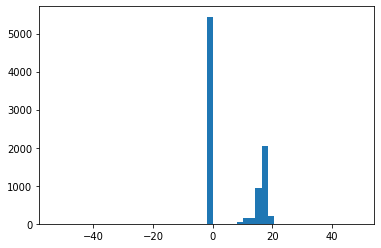

In [20]:
h = plt.hist(faceDisp.flatten(), bins=50, )

In [21]:
invalidDisp = np.zeros(faceDisp.shape, dtype='uint8')
invalidDisp[faceDisp <= 5] = 255
invalidDisp[faceDisp > 25] = 255
invalidDisp[masknew == 0] = 0

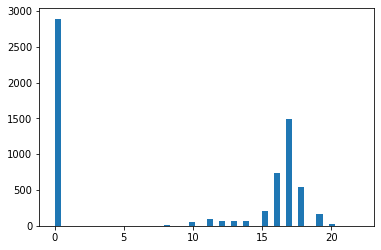

In [22]:
h = plt.hist(faceDisp[invalidDisp==0].flatten(), bins=50, )

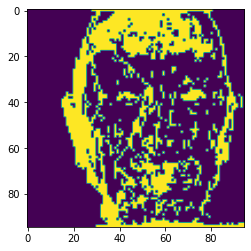

In [23]:
plt.imshow(invalidDisp)

In [24]:
rectifiedDisp = faceDisp.copy()
rectifiedInvalid = invalidDisp.copy()
avgs = np.zeros(faceDisp.shape)

for i in range(1, leftimg.shape[0]-1):
  for j in range(1, leftimg.shape[1]-1):
    if(invalidDisp[i,j]==255):
      sumDisp = 0
      validPix = 0
      
      for x in range(-1,2):
        for y in range(-1,2):
          #if(i==4 and j==42):
            #print(i+x,j+y,rectifiedDisp[i+x,j+y], (255-rectifiedInvalid[i+x,j+y]))
          sumDisp += rectifiedDisp[i+x,j+y]*(255-rectifiedInvalid[i+x,j+y])/255
          validPix += (255-rectifiedInvalid[i+x,j+y])/255

      if (validPix == 0):
        continue
      
      avgDisp = int(sumDisp/validPix)
      avgs[i,j] = avgDisp
      #if (avgDisp<0):
        #print(i,j,avgDisp)
      temp = leftimg[i-1:i+2, j-1:j+2]
      res = cv2.matchTemplate(rightimg[i-1:i+2,j-avgDisp-3:j-avgDisp+4], temp, cv2.TM_CCORR_NORMED)
      rectifiedDisp[i][j] = avgDisp - res.argmax() + 2
      rectifiedInvalid[i][j] = 0
      if(rectifiedDisp[i][j]<=0):
        rectifiedDisp[i][j] = 0
        rectifiedInvalid[i][j] = 255

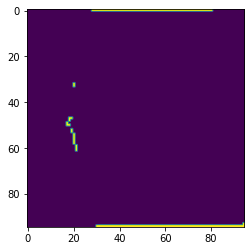

In [25]:
plt.imshow(rectifiedInvalid)

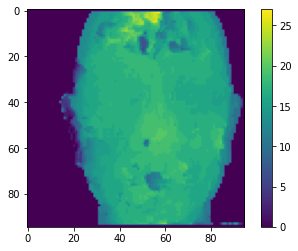

In [26]:
plt.imshow(rectifiedDisp)
plt.colorbar()

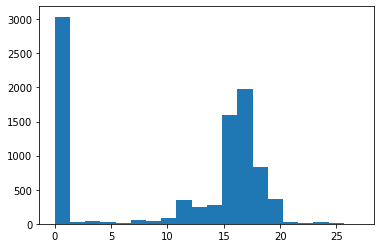

In [27]:
h=plt.hist(rectifiedDisp.flatten(),20)

# Transferring to bigger image

In [28]:
bigImgL = leftPyr[0]
bigImgR = rightPyr[0]
bigDisp = np.zeros(bigImgL.shape[:2])

In [29]:
for i in range(1, bigImgL.shape[0]-1):
  for j in range(1, bigImgL.shape[1]-1):
    if(maskL[i,j] == 0):
      continue

    smallDisp = rectifiedDisp[i//32][j//32]
    temp = bigImgL[i-1:i+2, j-1:j+2]
    res = cv2.matchTemplate(bigImgR[i-1:i+2,int(j-32*smallDisp-32):int(j-32*smallDisp+32)], temp, cv2.TM_CCORR_NORMED)
    bigDisp[i][j] = 32*smallDisp - (res.argmax() + 1) + 32

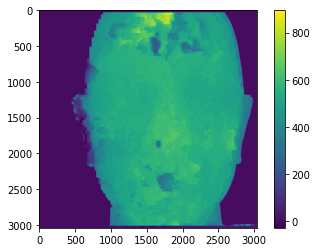

In [30]:
plt.imshow(bigDisp)
plt.colorbar()

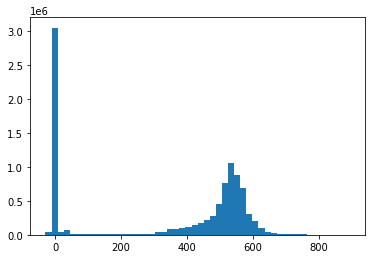

In [31]:
h = plt.hist(bigDisp.flatten(), 50)

In [32]:
disp = bigDisp.copy()
disp[bigDisp < 300] = 300
disp[bigDisp > 700] = 700

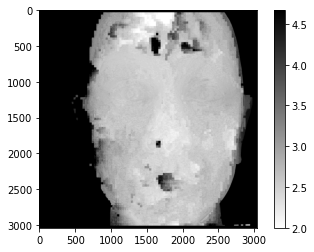

In [33]:
depthTest = 0.35*4000/disp
plt.imshow(depthTest, cmap='binary')
plt.colorbar()

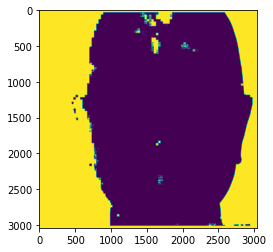

In [34]:
invalid = np.zeros(bigDisp.shape)
invalid[bigDisp < 300] = 255
invalid[bigDisp > 700] = 255
plt.imshow(invalid)

In [35]:
depth = np.zeros(bigDisp.shape)
depth[invalid == 0] = 4876.8*0.32/bigDisp[invalid==0]

In [36]:
x_points = []
y_points = []
z_points = []
colors = []

for i in range(0, bigImgL.shape[0]):
  for j in range(0, bigImgL.shape[1]):
    if (invalid[i][j] == 0):
      x_points.append(i)
      y_points.append(j)
      z_points.append(depth[i,j]*200)
      colors.append(bigImgL[i,j])

x_points = np.array(x_points)
y_points = np.array(y_points)
z_points = np.array(z_points)
c_array = np.array(colors)/255

In [50]:
index = np.random.choice(x_points.shape[0], 1000000, replace=False)  

<IPython.core.display.Javascript object>


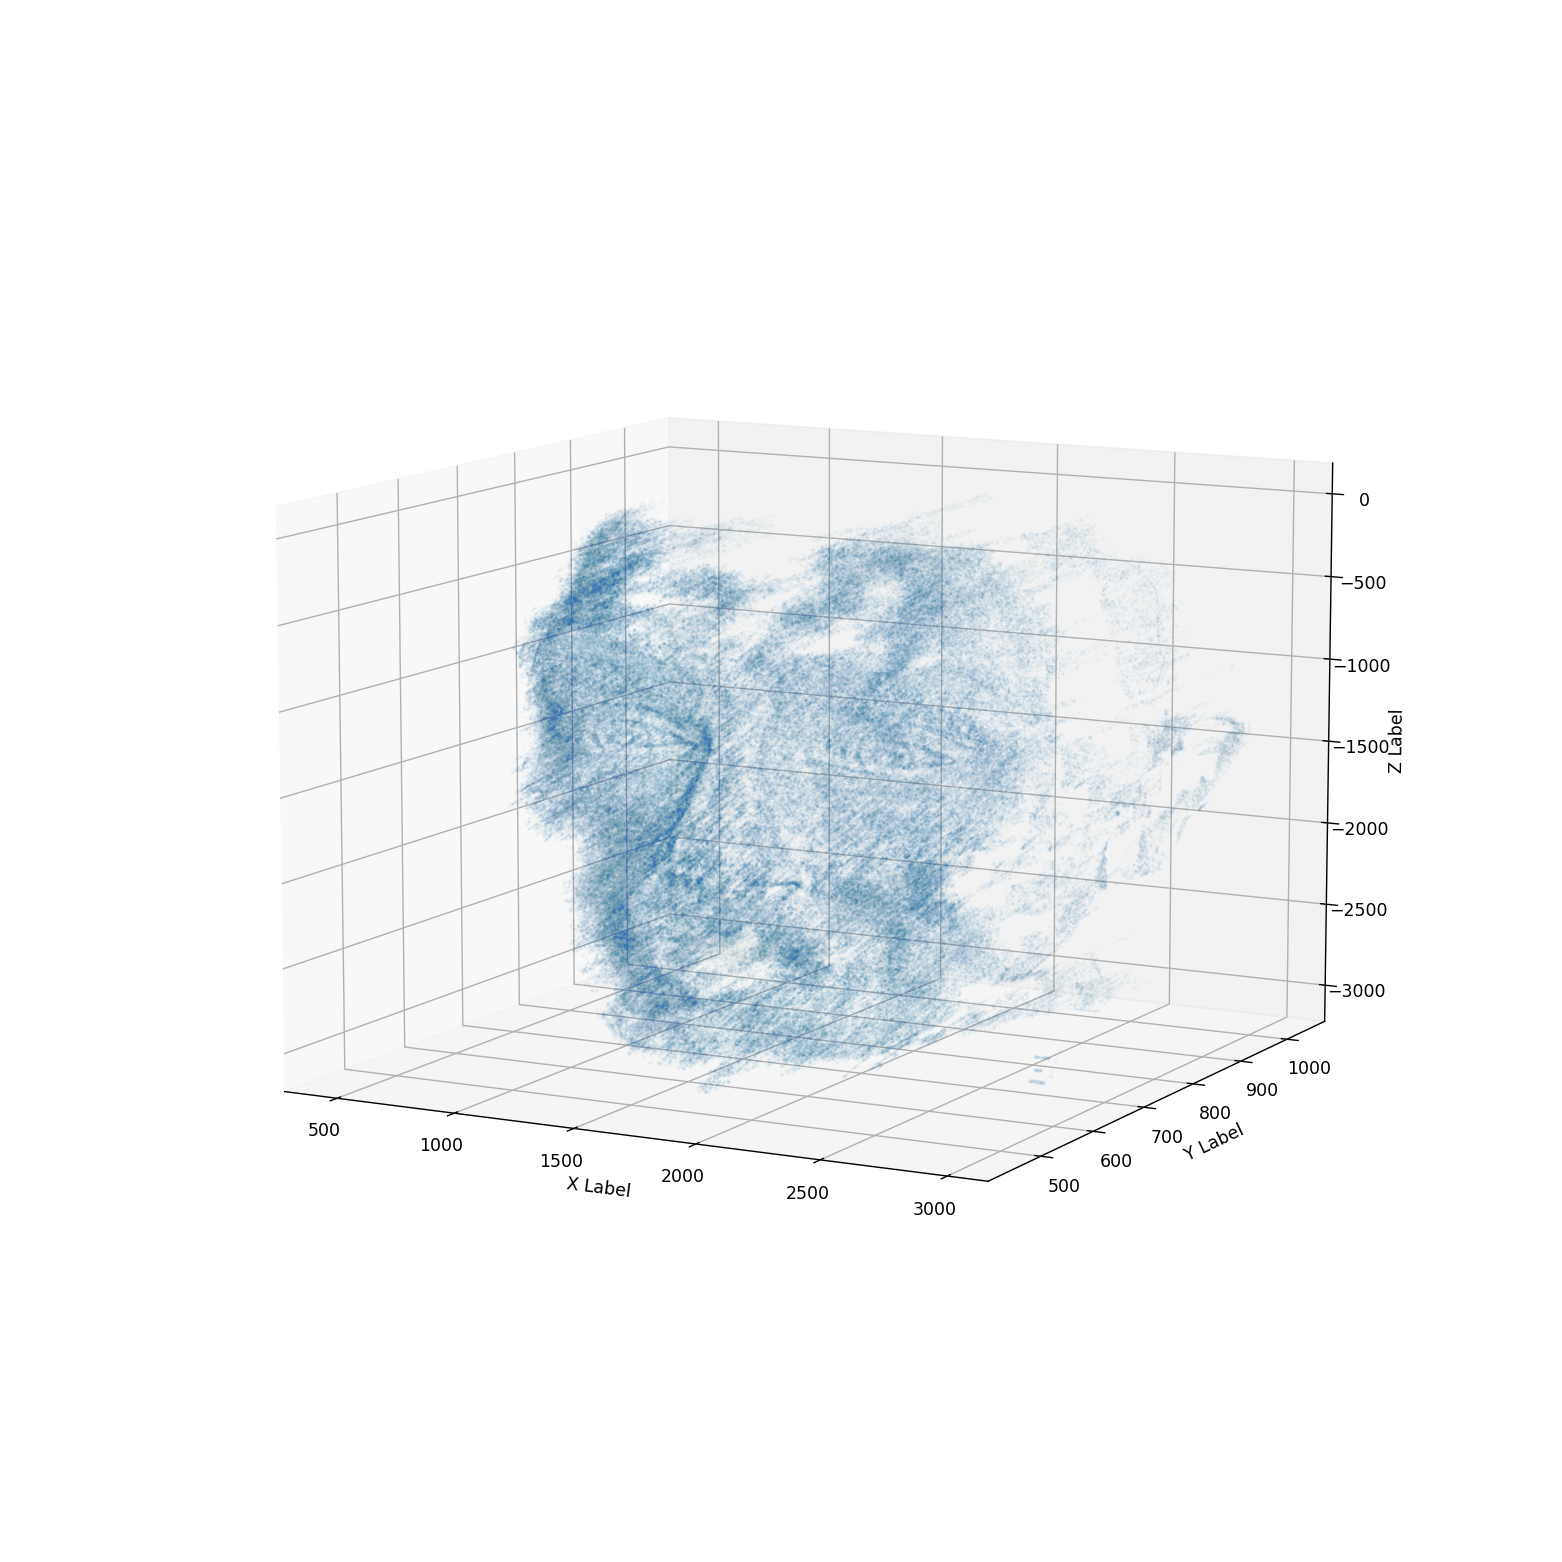

Text(0.5, 0, 'Z Label')

In [53]:
%matplotlib notebook
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")
ax.scatter(y_points[index], z_points[index], -1*x_points[index], s=0.001)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')